In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from glob import glob
import datetime
from numba import jit

import subroutines as subs

In [2]:
#---Code below moved to get_csat_amsr2_coinc.py

In [2]:
#---Read in from file:

indir = '/edata2/spencer/thesis_data/pop_csat_amsr2/'

flist = glob(indir+'/*.nc4')
flist.sort()

with xr.open_mfdataset(flist[:], concat_dim='pixels', combine='nested') as f:
    lat = f.Latitude.values
    lon = f.Longitude.values
    clw = f.CLW.values
    chisq = f.ChiSquared.values
    tpw = f.TPW.values
    sst = f.SST.values
    frz_lvl = f.FreezingLevel.values
    cslat = f.CloudSatLatitude.values
    cslon = f.CloudSatLongitude.values
    frac_occur = f.FractionOfOccurrence.values
    precip = f.PrecipRate.values
    sctime = f.ScanTime.values

In [3]:
precip_conds = {
    
    'cond1': (precip >= 0.001),
    'cond2': (precip >= 0.01),
    'cond3': (precip >= 0.1),
    'cond4': (precip >= 0.2),
    'cond5': (precip >= 0.5)
    
}

pop = {}

#---Loop through conditions specified above:
for i,icond in enumerate(precip_conds.keys()):
    
    print(icond)
    
    #Preallocate array for storing yes/no flags
    precip_yes_no = np.zeros(np.shape(clw), dtype='f')
    
    #Set flags satisfying precip condition to 1
    precip_yes_no[np.where(precip_conds[icond])] = 1
    
    #Create array of columns = clw, precip flags
    pop_clw = xr.DataArray([clw, precip_yes_no]).T
    
    #Sort array by ascending clw values
    pop_clw = pop_clw.sortby(pop_clw[:,0])
    
    #Create array of clw bins
    bin_edges = np.arange(0,1300,5)
    
    #preallocate array of binned clw and probability of precip for each bin
    binned_clw = np.zeros(bin_edges.size-1)
    pop_by_bin = np.zeros(bin_edges.size-1)
    
    #Loop through the bins
    for ibin in np.arange(0, bin_edges.size - 1):
        
        if ibin % 100 == 0:
            print(ibin)
        
        #Find all clw within the bin boundaries
        bin_edge1 = bin_edges[ibin]
        bin_edge2 = bin_edges[ibin + 1]
        
        all_clw = pop_clw[:,0]
        
        all_p = pop_clw[:,1]
        
        within_bin = np.logical_and(all_clw >= bin_edge1, all_clw < bin_edge2)
        
        #Take the mean of the precip flags to get the probability of precip for each clw bin
        prob_prcp = np.mean(all_p[within_bin])
        
        pop_by_bin[ibin] = prob_prcp
        
    pop[icond] = pop_by_bin


cond1
0
100
200
cond2
0
100
200
cond3
0
100
200
cond4
0
100
200
cond5
0
100
200


In [4]:
#---Get X^2 for each clw bin:

chisq_by_clw = xr.DataArray([clw, chisq]).T
chisq_by_clw = chisq_by_clw.sortby(chisq_by_clw[:,0])

all_clw   = chisq_by_clw[:,0]
all_chisq = chisq_by_clw[:,1]

mean_chisq_for_bin = np.zeros(bin_edges.size - 1)

for ibin in np.arange(bin_edges.size - 1):
    
    bin_edge1 = bin_edges[ibin]
    bin_edge2 = bin_edges[ibin + 1]
    
    within_bin = np.logical_and(all_clw >= bin_edge1, all_clw < bin_edge2)
    
    mean_chisq = np.mean(all_chisq[within_bin])
    
    mean_chisq_for_bin[ibin] = mean_chisq

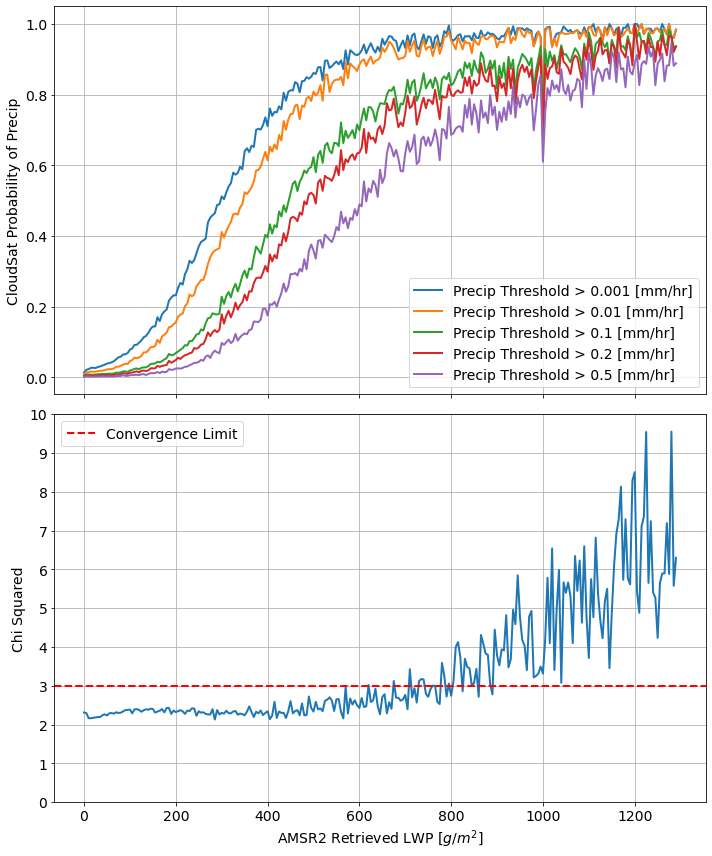

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10,12], sharex = True, tight_layout=True)

ax1 = ax[0]
ax2 = ax[1]

ax1.plot(bin_edges[:-1], pop['cond1'], label='Precip Threshold > 0.001 [mm/hr]',
         linewidth=2)
ax1.plot(bin_edges[:-1], pop['cond2'], label='Precip Threshold > 0.01 [mm/hr]',
         linewidth=2)
ax1.plot(bin_edges[:-1], pop['cond3'], label='Precip Threshold > 0.1 [mm/hr]',
         linewidth=2)
ax1.plot(bin_edges[:-1], pop['cond4'], label='Precip Threshold > 0.2 [mm/hr]',
         linewidth=2)
ax1.plot(bin_edges[:-1], pop['cond5'], label='Precip Threshold > 0.5 [mm/hr]',
         linewidth=2)

ax2.plot(bin_edges[:-1], mean_chisq_for_bin, linewidth=2)


#ax.set_xlim(0,600)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

ax2.set_xlabel('AMSR2 Retrieved LWP [$g/m^2$]', fontsize=14)
ax1.set_ylabel('CloudSat Probability of Precip', fontsize=14)
ax2.set_ylabel('Chi Squared', fontsize=14)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax2.set_yticks(np.arange(0,11.0,1.0))

ax2.axhline(3, linewidth=2, color='r', linestyle='--', label='Convergence Limit')

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax1.grid()
ax2.grid()

plt.show()